# Cell Detection with Contour Proposal Networks

<img src="bbbc039-cpn-u22-demo.png" />

In this tutorial you will learn how to use [Contour Proposal Networks](https://arxiv.org/abs/2104.03393) (CPN) for Cell Detection with the 
[BBBC039](https://bbbc.broadinstitute.org/BBBC039) dataset and [PyTorch](https://pytorch.org/get-started/locally/).

## Really quick: What is a Contour Proposal Network?
For a given image the Contour Proposal Network proposes **pixel-precise object contours**, each outlining an entire object. Like other detection networks, the CPN uses a so called backbone network to compute its features. This could be for example a ResNet-FPN ([Feature Pyramid Network](https://arxiv.org/abs/1612.03144) with [ResNet](https://arxiv.org/abs/1512.03385)), or a standard [U-Net](https://arxiv.org/abs/1505.04597) to name just two of many other options.

So it works kind of like bounding box regression models, such as [YOLO](https://arxiv.org/pdf/1506.02640.pdf) or [Region Proposal Networks](https://arxiv.org/abs/1506.01497), but with contours.

You can find a detailed description on arXiv: https://arxiv.org/abs/2104.03393.

## What is covered here?
1. [Install source](#1.-Install-pip-install-celldetection)
2. [The configuration](#2.-The-configuration)
3. [The data](#3.-The-data)
4. [The Contour Proposal Network](#4.-The-Contour-Proposal-Network)
5. [Training](#5.-Training)
6. [Evaluation and FPS measurement](#Testing-and-inference-speed)
7. [Conclusion](#7.-Conclusion)

## Automatic Mixed Precision (AMP)
This tutorial includes support for PyTorch's [**Automatic Mixed Precision package**](https://pytorch.org/docs/stable/amp.html). You can enable and disable it in [section 2](#2.-The-configuration) (`conf.amp`) of this tutorial.
If enabled, it will automatically select certain parts of the model to use *float16*. Some operations, like convolutions, are much faster this way. AMP can be applied both during training and testing.

## 1. Install `pip install celldetection`

<hr/>

First make sure that you have installed [PyTorch](https://pytorch.org/get-started/locally). Follow the link for more information.

To install `CellDetection`, you can simply use pip: `pip install celldetection`

In [1]:
import torch
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

In [2]:
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn

In [3]:
from matplotlib import pyplot as plt
from collections import OrderedDict
import albumentations as A
import celldetection as cd
from tqdm import tqdm
import numpy as np
import os

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
cd.__version__

'0.2.2'

## 2. The configuration
<hr/>
The most important settings are stored in this `Config` object. You can save it with `conf.to_json('config.json')` and load it with `cd.Config.from_json('config.json')`. This is especially helpful if you plan to test many different configurations.

The config includes among other things the optimizer choice, batch size, specific CPN architecture and settings, crop size and number of epochs.

In [6]:
conf = cd.Config(
    # data
    directory='./data',
    download_data=True,
    in_channels=1,
    classes=2,
    shuffle=True,
    bg_fg_dists=(0.8, 0.85),
    crop_size=(256, 256),
    
    # cpn
    cpn='CpnU22',  # see https://git.io/JOnWX for alternatives
    score_thresh=.9,
    val_score_threshs=(.6, .8, .9),
    nms_thresh=.5,
    val_nms_threshs=(.3, .5, .8),
    contour_head_stride=2,
    order=6,  # the higher, the more complex shapes can be detected
    samples=64,  # number of coordinates per contour
    refinement_iterations=3,
    refinement_buckets=6,
    tweaks={
        'BatchNorm2d': {'momentum': 0.05}
    },
    
    # optimizer
    optimizer={'Adam': {'lr': 0.0008, 'betas': (0.9, 0.999)}},
    scheduler={'StepLR': {'step_size': 5, 'gamma': .99}},
    
    # training
    epochs=100,
    steps_per_epoch=512,
    batch_size=8,
    amp=torch.cuda.is_available(),  # Automatic Mixed Precision (https://pytorch.org/docs/stable/amp.html)
    
    # testing
    test_batch_size=4,
    
    # misc
    num_workers=0,  #8 * int(os.name != 'nt'),
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
)
print(conf)

Config(
  (directory): './data'
  (download_data): True
  (in_channels): 1
  (classes): 2
  (shuffle): True
  (bg_fg_dists): (0.8, 0.85)
  (crop_size): (256, 256)
  (cpn): 'CpnU22'
  (score_thresh): 0.9
  (val_score_threshs): (0.6, 0.8, 0.9)
  (nms_thresh): 0.5
  (val_nms_threshs): (0.3, 0.5, 0.8)
  (contour_head_stride): 2
  (order): 6
  (samples): 64
  (refinement_iterations): 3
  (refinement_buckets): 6
  (tweaks): {'BatchNorm2d': {'momentum': 0.05}}
  (optimizer): {'Adam': {'lr': 0.0008, 'betas': (0.9, 0.999)}}
  (scheduler): {'StepLR': {'step_size': 5, 'gamma': 0.99}}
  (epochs): 100
  (steps_per_epoch): 512
  (batch_size): 8
  (amp): True
  (test_batch_size): 4
  (num_workers): 0
  (device): 'cuda'
)


## 3. The data
<hr/>

### Loading data
Here, we load the data. If you already have a local copy of the BBBC039 dataset make sure to include the correct directory in the config and to disable the download option.
Otherwise, the following code will automatically download the data from the Broad Institute: https://bbbc.broadinstitute.org/BBBC039.

In [7]:
train_bbbc039 = cd.data.BBBC039Train(conf.directory, download=conf.download_data)
val_bbbc039 = cd.data.BBBC039Train(conf.directory)
test_bbbc039 = cd.data.BBBC039Train(conf.directory)

Using downloaded and verified file: ./data/images.zip
Extracting ./data/images.zip to ./data
Using downloaded and verified file: ./data/metadata.zip
Extracting ./data/metadata.zip to ./data
Using downloaded and verified file: ./data/masks.zip
Extracting ./data/masks.zip to ./data


### Transformations with [Albumentations](https://albumentations.ai/)

Data augmentation is a very popular strategy to improve training. Below you find a very basic setup, feel free to test different configurations.

In [8]:
transforms = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    A.RandomGamma((42, 100)),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.OpticalDistortion(shift_limit=0.01, p=0.3, interpolation=0, border_mode=0),
])

### Visualizing transformations

In [9]:
def demo_transforms(img, lbl, name=None):
    img = cd.data.normalize_percentile(img.copy().squeeze(), percentile=99.8)
    lbl = lbl.copy()
    
    # Show original
    cd.vis.show_detection(img, contours=cd.data.labels2contours(lbl), contour_linestyle='-')
    if name is not None:
        plt.title(name)
    plt.show()
    
    # Show transformed
    s = 3
    plt.figure(None, (s * 9, s * 9))
    for i in range(1, s * s + 1):
        plt.subplot(s, s, i)
        trans = transforms(image=img, mask=lbl.astype('int32'))
        t_img, t_lbl = trans['image'], trans['mask']
        cd.data.relabel_(t_lbl[..., None])
        plt.title(f'transformed {t_img.dtype.name, t_img.shape, t_lbl.dtype.name, t_lbl.shape}')
        cd.vis.show_detection(t_img, contours=cd.data.labels2contours(t_lbl), contour_linestyle='-')
    plt.show()

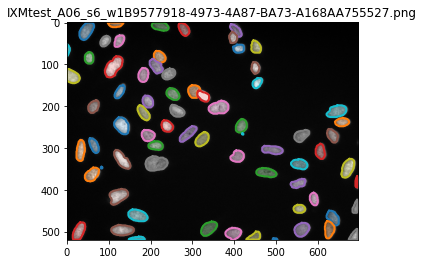

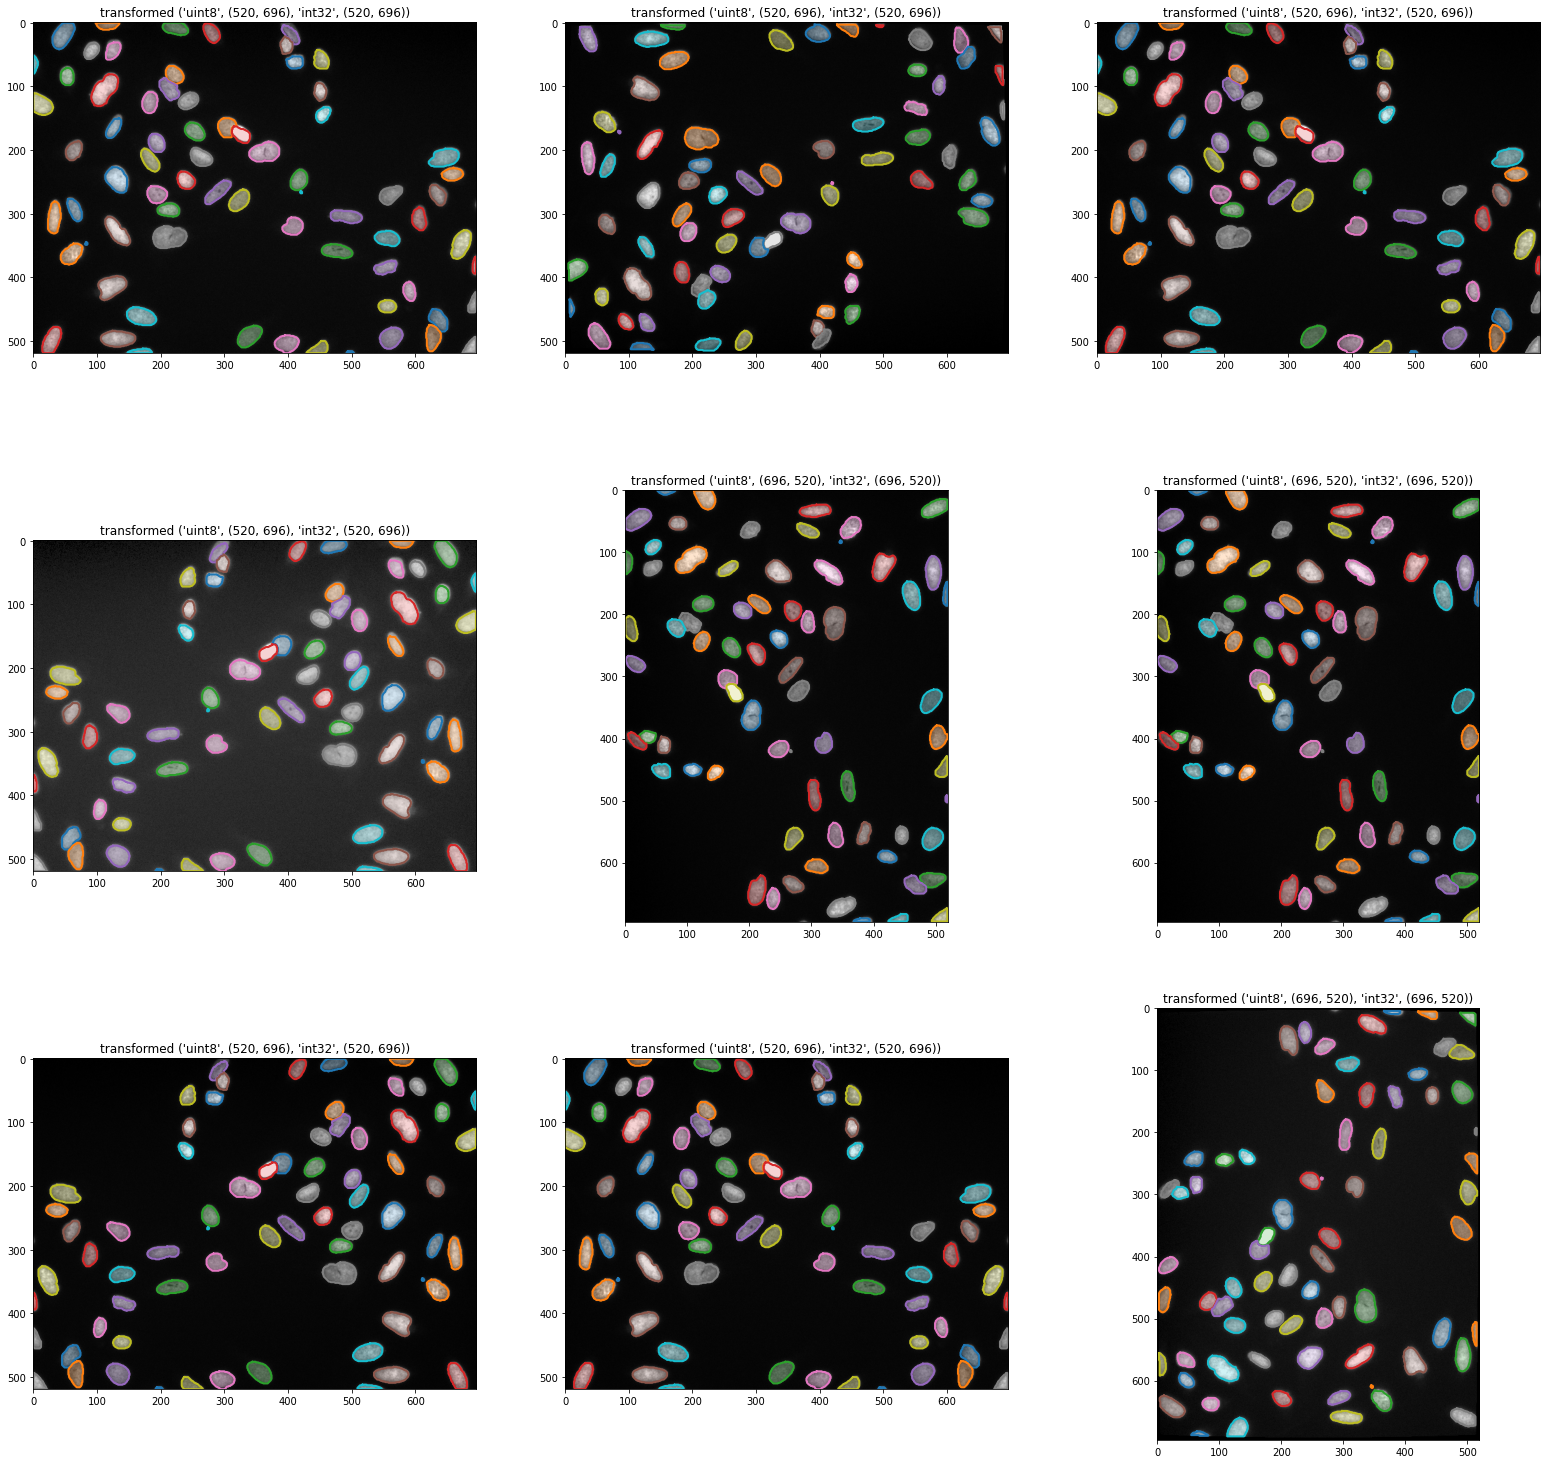

In [10]:
name, img, _, lbl = train_bbbc039[0]
demo_transforms(img, lbl, name)

### Dataset

In [11]:
class Data:
    def __init__(self, data, config, transforms=None, items=None, size=None):
        self.transforms = transforms
        self.gen = cd.data.CPNTargetGenerator(
            samples=config.samples,
            order=config.order,
            max_bg_dist=config.bg_fg_dists[0],
            min_fg_dist=config.bg_fg_dists[1],
        )
        self._items = items or len(data)
        self.data = data
        self.size = size
        self.channels = config.in_channels

    def __len__(self):
        return self._items

    @staticmethod
    def map(image):
        image = image / 127.5
        image -= 1
        if image.ndim == 2:
            image = image[..., None]
        return image.astype('float32')

    @staticmethod
    def unmap(image):
        image = (image + 1) * 127.5
        image = np.clip(image, 0, 255).astype('uint8')
        if image.ndim == 3 and image.shape[2] == 1:
            image = np.squeeze(image, 2)
        return image

    def __getitem__(self, item):
        if item >= len(self):
            raise IndexError('Index out of bounds.')
        item = item % len(self.data)
        
        # Get image and labels
        name, img, _, labels = self.data[item]
        
        # Normalize intensities
        img, labels = np.copy(img).squeeze(), np.copy(labels)
        img = cd.data.normalize_percentile(img, percentile=99.8)
        labels = labels.astype('int32')       
        
        # Optionally crop
        if self.size is not None:
            h, w = self.size
            img, labels = cd.data.random_crop(img, labels, height=h, width=w)
        
        # Optionally transform
        if self.transforms is not None:
            r = self.transforms(image=img, mask=labels)
            img, labels = r['image'], r['mask']

        # Ensure channels exist
        if labels.ndim == 2:
            labels = labels[..., None]
        
        # Relabel to ensure that N objects are marked with integers 1..N
        cd.data.relabel_(labels)
        
        # Feed labels to target generator
        gen = self.gen
        gen.feed(labels=labels)
        
        # Map image to range -1..1
        image = self.map(img)
        
        # Return as dictionary
        return OrderedDict({
            'inputs': image,
            'labels': gen.reduced_labels,
            'fourier': (gen.fourier.astype('float32'),),
            'locations': (gen.locations.astype('float32'),),
            'sampled_contours': (gen.sampled_contours.astype('float32'),),
            'sampling': (gen.sampling.astype('float32'),),
            'targets': labels
        })

In [12]:
train_data = Data(train_bbbc039, conf, transforms, items=conf.steps_per_epoch * conf.batch_size,
                  size=conf.crop_size)
val_data = Data(val_bbbc039, conf)
test_data = Data(test_bbbc039, conf)

### Data Loader

In [13]:
train_loader = DataLoader(train_data, batch_size=conf.batch_size, num_workers=conf.num_workers,
                          collate_fn=cd.universal_dict_collate_fn, shuffle=conf.shuffle)
val_loader = DataLoader(val_data, batch_size=conf.test_batch_size, collate_fn=cd.universal_dict_collate_fn)
test_loader = DataLoader(test_data, batch_size=1, collate_fn=cd.universal_dict_collate_fn)

### Visualizing the data
Here, we take a look at the data. What you see here, is what the network will learn to produce.
Specifically, we can see if the data is processed correctly, the intensity range is adequate, and also visualize the effect of the Contour Proposal Network's `order` hyperparameter.

In [14]:
def plot_example(data_loader, figsize=(8, 4.5)):
    # Pick example
    example = cd.asnumpy(next(iter(data_loader)))
    contours = example['sampled_contours'][0]
    image = cd.data.channels_first2channels_last(example['inputs'][0])
    # Plot example
    cd.vis.show_detection(image, contours=contours, figsize=figsize, contour_linestyle='-',
                          cmap='gray' if image.shape[2] == 1 else ...)
    plt.colorbar()
    plt.tight_layout()
    plt.ylim([0, image.shape[0]])
    plt.xlim([0, image.shape[1]])

In [15]:
def order_plot(data, data_loader):
    # Plot example data for different `order` settings
    gen = data.gen
    s = int(np.ceil(np.sqrt(conf.order)))
    plt.figure(None, (s * 12, s * 6.75))
    for gen.order in range(1, conf.order + 1):
        plt.subplot(s, s, gen.order)
        plot_example(data_loader, figsize=None)
        plt.title(f'{"Chosen o" if gen.order == conf.order else "O"}rder: {gen.order}')
    plt.show()
    assert gen.order == conf.order

#### Training data

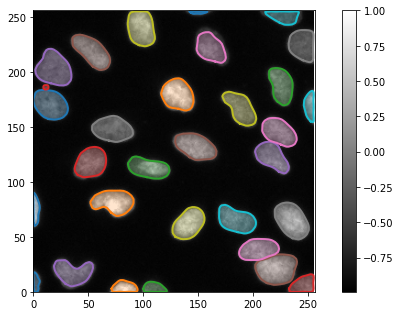

In [16]:
plot_example(train_loader)

#### Validation data with different `order` settings

The `order` hyperparameter controls how complicated the contours can be.
While `order = 1` only yields ellipses, higher settings add more and more detail.
Notably, you can always reduce the `order` after training a CPN. However, increasing it requires additional convolutional layers.

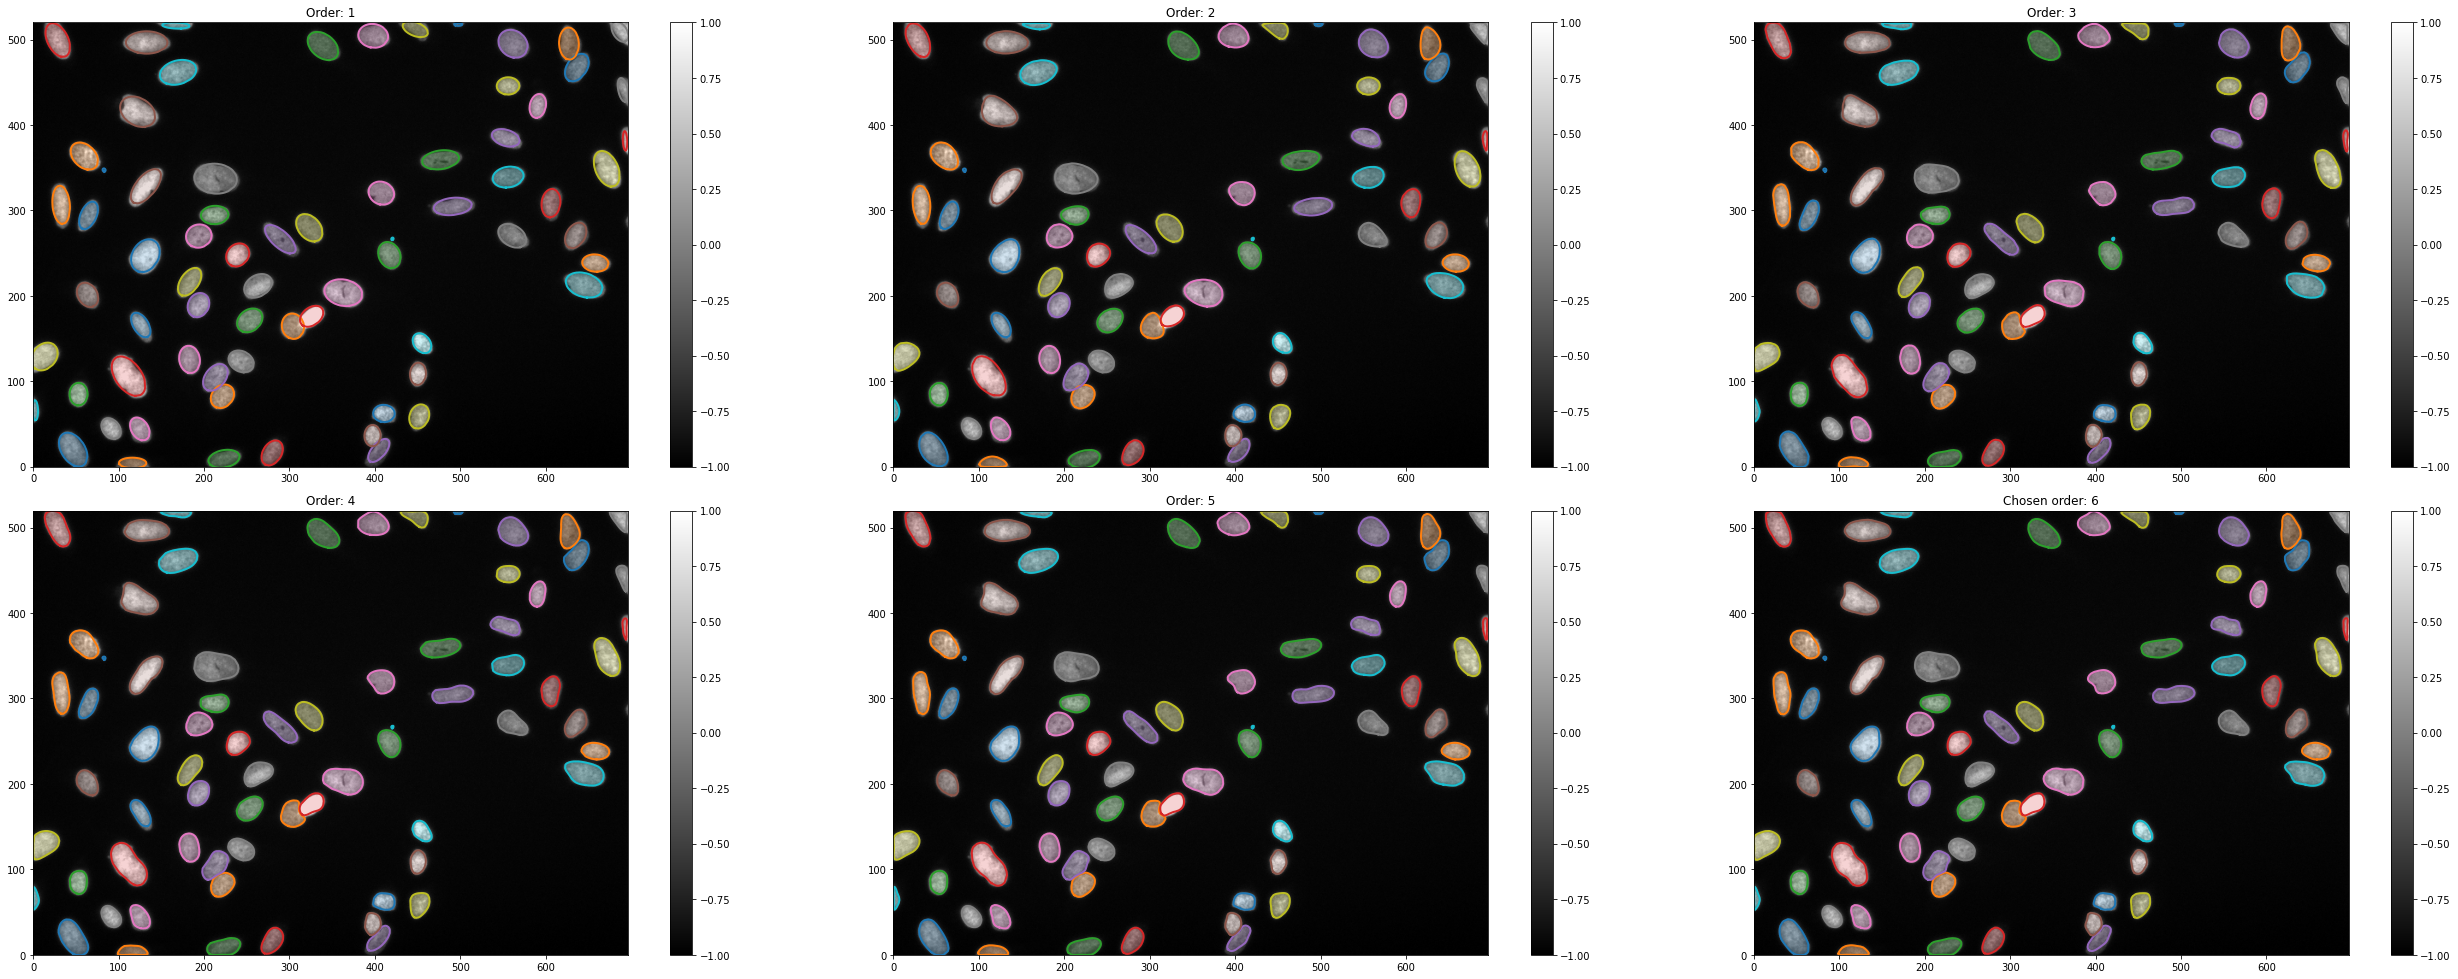

In [17]:
order_plot(val_data, val_loader)

## 4. The Contour Proposal Network

<hr/>

This code snippet defines the actual model and allows for some tweaks to its settings, as specified in the config.
Here, `conf.cpn` can either be a class name, a file name of a PyTorch checkpoint, a url of a PyTorch checkpoint, or the name of a *pretrained model* hosted by `celldetection`.

In [18]:
if conf.cpn in dir(cd.models):
    model = getattr(cd.models, conf.cpn)(
        in_channels=conf.in_channels, order=conf.order, samples=conf.samples,
        refinement_iterations=conf.refinement_iterations, nms_thresh=conf.nms_thresh,
        score_thresh=conf.score_thresh, contour_head_stride=conf.contour_head_stride,
        classes=conf.classes, refinement_buckets=conf.refinement_buckets
    ).to(conf.device)
elif os.path.isfile(conf.cpn):
    model = torch.load(conf.cpn, map_location=conf.device)
else:
    model = cd.fetch_model(conf.cpn, map_location=conf.device)
if conf.tweaks is not None:
    cd.conf2tweaks_(conf.tweaks, model)

## 5. Training

<hr/>

### Optimizer, scheduler and gradient scaler

Define the optimizer and scheduler according to the config.
The gradient scaler only used when automated mixed precision is enabled for training.

In [19]:
optimizer = cd.conf2optimizer(conf.optimizer, model.parameters())
scheduler = cd.conf2scheduler(conf.scheduler, optimizer)
scaler = GradScaler() if conf.amp else None

### Training functions

In [20]:
def train_epoch(model, data_loader, device, optimizer, desc=None, scaler=None, scheduler=None, progress=True):
    model.train()
    tq = tqdm(data_loader, desc=desc) if progress else data_loader
    for batch_idx, batch in enumerate(tq):
        batch: dict = cd.to_device(batch, device)
        optimizer.zero_grad()
        with autocast(scaler is not None):
            outputs: dict = model(batch['inputs'], targets=batch)
        loss = outputs['loss']
        if progress:
            info = [desc] if desc is not None else []
            info += ['loss %g' % np.round(cd.asnumpy(loss), 3)]
            tq.desc = ' - '.join(info)
        if scaler is None:
            loss.backward()
            optimizer.step()
        else:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    if scheduler is not None:
        scheduler.step()

In [21]:
def show_results(model, test_loader, device):
    model.eval()
    batch = cd.to_device(next(iter(test_loader)), device)
    with torch.no_grad():
        outputs = model(batch['inputs'])
    o = cd.asnumpy(outputs)
    num = len(o['contours'])
    s = int(np.ceil(np.sqrt(num)))
    plt.figure(None, (s * 24, s * 13.5))
    for idx in range(num):
        plt.subplot(s, s, idx + 1)
        image = cd.asnumpy(batch['inputs'][idx])
        cd.vis.show_detection(Data.unmap(image.transpose(1, 2, 0)), contours=o['contours'][idx],
                              contour_linestyle='-', scores=o['scores'][idx])
    plt.show()

### Training loop
This basic training loop runs for a specified number of epochs and plots an example prediction from the test dataset every now and then.

In [ ]:
for epoch in range(1, conf.epochs + 1):
    train_epoch(model, train_loader, conf.device, optimizer, f'Epoch {epoch}/{conf.epochs}', scaler, scheduler)
    if epoch % 10 == 0:
        show_results(model, test_loader, conf.device)

## 6. Evaluation and FPS measurement

<hr/>

### Detection and segmentation peformance

To evaluate the detection performance and the shape quality of the produced contours we use the harmoc mean of precision and reall
$$\text{F1}_\tau=\frac{TP_\tau}{TP_\tau+\frac{1}{2}(FP_\tau+FN_\tau)}$$
for different *Intersection over Union* (IoU) thresholds $\tau$.
The IoU threshold $\tau \in[0,1]$ defines the minimal IoU that is required for two shapes to be counted as a match. 
Each ground truth shape can be a match for at most one predicted shape.
A True Positive $(\text{TP})$ is a predicted shape that matches a ground truth shape, a False Positive ($\text{FP}$) is a shape that does not match any ground truth shape and a False Negative ($\text{FN}$) is a ground truth shape that does not match any predicted shape.

### Validation
Here, we use the validation split of our dataset to determine which settings yield the best results.
The settings that yield the highest average F1 score during validation are used to evaluate the model on the dataset's test split.

In [ ]:
def avg_iou_score(results, iou_threshs=(.5, .6, .7, .8, .9), verbose=True):
    scores = []
    if verbose:
        print('iou thresh\t\t f1')
    for results.iou_thresh in iou_threshs:
        scores.append(results.avg_f1)
        if verbose:
            print(results.iou_thresh, '\t\t\t', np.round(scores[-1], 3))
    final_f1 = np.mean(scores).round(3)
    if verbose:
        print('\nAverage F1 score:', '\t', final_f1)
    return final_f1

In [ ]:
def evaluate(model, data_loader, device, use_amp, desc='Eval', progress=True, timing=False):
    """Evaluate model and return results."""
    model.eval()
    tq = tqdm(data_loader, desc=desc) if progress else data_loader
    results = cd.data.LabelMatcherList()
    times = []
    for batch_idx, batch in enumerate(tq):
        batch: dict = cd.to_device(batch, device)
        with autocast(use_amp):
            if timing:
                cd.start_timer('bbbc039')
            outputs: dict = model(batch['inputs'])
            if timing:
                times.append(cd.stop_timer('bbbc039', verbose=False))
        out = cd.asnumpy(outputs)
        inp = cd.asnumpy(batch)
        targets = inp['targets']
        for idx in range(len(targets)):
            target = cd.data.channels_first2channels_last(targets[idx])
            prediction = cd.data.contours2labels(out['contours'][idx], target.shape[:2])
            results.append(cd.data.LabelMatcher(prediction, target))
    if len(times) > 0:
        cd.print_timing('Average prediction delay', np.mean(times))
        print("FPS:", ' ' * 66, (1 / np.mean(times)).round(2), 'frames')
    return results

In [ ]:
def validate_(model, data_loader, device, use_amp):
    """Validate model with different settings, keep best performing settings."""
    best_f1 = 0.
    best_settings = {}
    for model.score_thresh in conf.val_score_threshs:
        for model.nms_thresh in conf.val_nms_threshs:
            res = evaluate(model, val_loader, conf.device, use_amp,
                           desc=f'Validate (score thresh: {model.score_thresh}, nms_thresh: {model.nms_thresh})')
            f1 = avg_iou_score(res, verbose=False)
            if f1 > best_f1:
                best_f1 = f1
                best_settings['score_thresh'] = model.score_thresh
                best_settings['nms_thresh'] = model.nms_thresh
    for k, v in best_settings.items():
        print(f'Best {k}: {v}')
        setattr(model, k, v)
    print("Val f1 score:", best_f1)

In [ ]:
validate_(model, val_loader, conf.device, conf.amp)

### Testing and inference speed
Finally, we want to evaluate the model's performance on the test dataset.
For this, we measure the average F1 score, as well as FPS (frames per second).
The latter is especially important, since practical uses cases of cell detection often involve scans or images with tens or even hundreds of thousands of pixels in height and width.

Since the test loader uses a batch size of 1, we can also measure the time that the model needs to predict contours for a single image. This per image delay can be averaged and used to get an estimated count for FPS.
In this case all images have size **(520, 696)**.

In [ ]:
test_results = evaluate(model, test_loader, conf.device, conf.amp, timing=True)

In [ ]:
final_f1 = avg_iou_score(test_results)

## 7. Conclusion

<hr/>

You are now able to use [Contour Proposal Networks](https://arxiv.org/abs/2104.03393) for Cell Detection.
Feel free to try different settings, CPN architectures and also datasets.

Since the only assumption of the CPN's contour approach are closed object contours, it is applicable to a wide range of detection problems, also outside the biomedical domain that have not been investigated yet.

On [celldetection.org](https://celldetection.org) or [https://git.io/JOnWX](https://git.io/JOnWX) you will find additional resources and examples.